In [1]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

print("Libraries imported successfully.")


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Libraries imported successfully.


[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
# Upload dataset files manually (Fake.csv and True.csv)

from google.colab import files

uploaded = files.upload()

fake_df = pd.read_csv('Fake.csv')
true_df = pd.read_csv('True.csv')

fake_df.head(), true_df.head()


Saving Fake.csv to Fake.csv
Saving True.csv to True.csv


(                                               title  \
 0   Donald Trump Sends Out Embarrassing New Year’...   
 1   Drunk Bragging Trump Staffer Started Russian ...   
 2   Sheriff David Clarke Becomes An Internet Joke...   
 3   Trump Is So Obsessed He Even Has Obama’s Name...   
 4   Pope Francis Just Called Out Donald Trump Dur...   
 
                                                 text subject  \
 0  Donald Trump just couldn t wish all Americans ...    News   
 1  House Intelligence Committee Chairman Devin Nu...    News   
 2  On Friday, it was revealed that former Milwauk...    News   
 3  On Christmas day, Donald Trump announced that ...    News   
 4  Pope Francis used his annual Christmas Day mes...    News   
 
                 date  
 0  December 31, 2017  
 1  December 31, 2017  
 2  December 30, 2017  
 3  December 29, 2017  
 4  December 25, 2017  ,
                                                title  \
 0  As U.S. budget fight looms, Republicans flip t...   
 1  U

In [3]:
#Add labels and combine

fake_df['label'] = 0
true_df['label'] = 1

fake_df = fake_df[['title', 'text', 'label']]
true_df = true_df[['title', 'text', 'label']]

data = pd.concat([fake_df, true_df], axis=0).reset_index(drop=True)

print("Shape of combined data:", data.shape)
data.head()


Shape of combined data: (44898, 3)


,title,text,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0


Number of missing values per column:
title    0
text     0
label    0
dtype: int64

Class distribution (0 = Fake, 1 = Real):
label
0    23481
1    21417
Name: count, dtype: int64


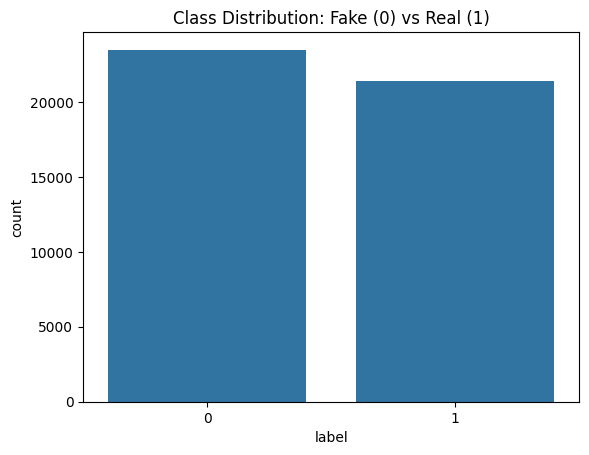

In [4]:
# Basic exploration

print("Number of missing values per column:")
print(data.isnull().sum())

print("\nClass distribution (0 = Fake, 1 = Real):")
print(data['label'].value_counts())

sns.countplot(x='label', data=data)
plt.title('Class Distribution: Fake (0) vs Real (1)')
plt.show()


In [5]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
# Text cleaning & preprocessing

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

data['content'] = data['title'].fillna('') + " " + data['text'].fillna('')

data['clean_content'] = data['content'].apply(clean_text)

data[['content', 'clean_content', 'label']].head()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,content,clean_content,label
0,Donald Trump Sends Out Embarrassing New Year’...,donald trump sends embarrassing new year ’ eve...,0
1,Drunk Bragging Trump Staffer Started Russian ...,drunk bragging trump staffer started russian c...,0
2,Sheriff David Clarke Becomes An Internet Joke...,sheriff david clarke becomes internet joke thr...,0
3,Trump Is So Obsessed He Even Has Obama’s Name...,trump obsessed even obama ’ name coded website...,0
4,Pope Francis Just Called Out Donald Trump Dur...,pope francis called donald trump christmas spe...,0


In [7]:
print(data.columns)
data.head()


Index(['title', 'text', 'label', 'content', 'clean_content'], dtype='object')


,title,text,label,content,clean_content
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,0,Donald Trump Sends Out Embarrassing New Year’...,donald trump sends embarrassing new year ’ eve...
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,0,Drunk Bragging Trump Staffer Started Russian ...,drunk bragging trump staffer started russian c...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",0,Sheriff David Clarke Becomes An Internet Joke...,sheriff david clarke becomes internet joke thr...
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",0,Trump Is So Obsessed He Even Has Obama’s Name...,trump obsessed even obama ’ name coded website...
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,0,Pope Francis Just Called Out Donald Trump Dur...,pope francis called donald trump christmas spe...


In [8]:
# Train-test split and TF-IDF

X = data['clean_content']
y = data['label']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF train shape:", X_train_tfidf.shape)
print("TF-IDF test shape:", X_test_tfidf.shape)


Train size: 35918
Test size: 8980
TF-IDF train shape: (35918, 5000)
TF-IDF test shape: (8980, 5000)


 Naive Bayes 
Accuracy: 0.942761692650334

Classification report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      4696
           1       0.94      0.94      0.94      4284

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



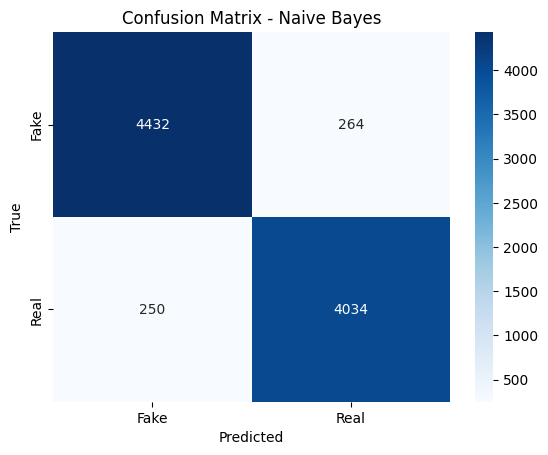

In [9]:
# Evaluation helper + Naive Bayes model

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

results = []

def evaluate_model(name, y_true, y_pred, results_list):
    acc = accuracy_score(y_true, y_pred)
    print(f" {name} ")
    print("Accuracy:", acc)
    print("\nClassification report:")
    print(classification_report(y_true, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=['Fake', 'Real'],
        yticklabels=['Fake', 'Real']
    )
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    results_list.append({'Model': name, 'Accuracy': acc})


# Naive Bayes classifier
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

y_pred_nb = nb_model.predict(X_test_tfidf)

evaluate_model("Naive Bayes", y_test, y_pred_nb, results)


 Random Forest 
Accuracy: 0.998218262806236

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4696
           1       1.00      1.00      1.00      4284

    accuracy                           1.00      8980
   macro avg       1.00      1.00      1.00      8980
weighted avg       1.00      1.00      1.00      8980



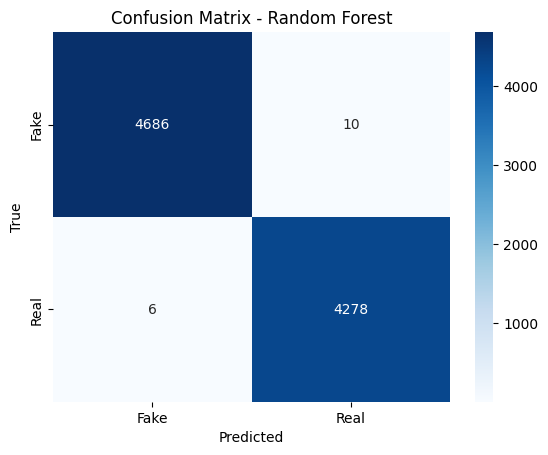

In [10]:
# Random Forest classifier

from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_tfidf, y_train)
y_pred_rf = rf_model.predict(X_test_tfidf)

evaluate_model("Random Forest", y_test, y_pred_rf, results)


 Logistic Regression 
Accuracy: 0.9881959910913141

Classification report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4696
           1       0.98      0.99      0.99      4284

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



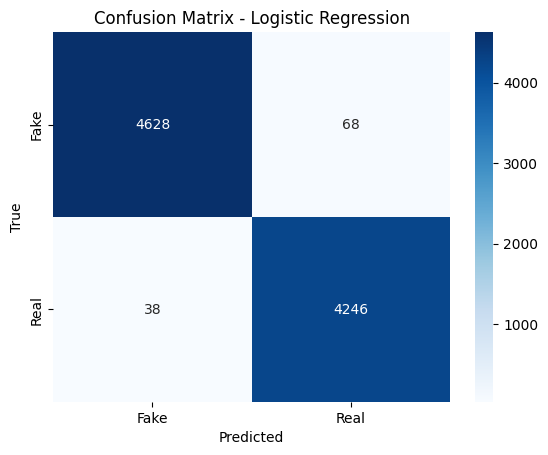


Model comparison (by accuracy):
                 Model  Accuracy
1        Random Forest  0.998218
2  Logistic Regression  0.988196
0          Naive Bayes  0.942762


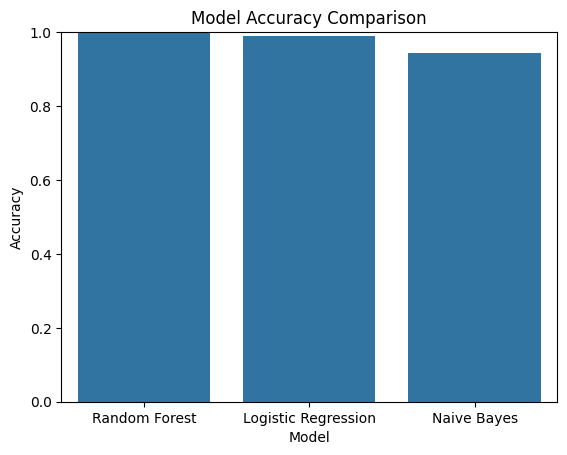

In [11]:
# Logistic Regression + model comparison

from sklearn.linear_model import LogisticRegression

log_reg_model = LogisticRegression(max_iter=1000)
log_reg_model.fit(X_train_tfidf, y_train)

y_pred_lr = log_reg_model.predict(X_test_tfidf)

evaluate_model("Logistic Regression", y_test, y_pred_lr, results)

results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
print("\nModel comparison (by accuracy):")
print(results_df)

plt.figure()
sns.barplot(x='Model', y='Accuracy', data=results_df)
plt.ylim(0, 1)
plt.title('Model Accuracy Comparison')
plt.show()


In [12]:
# Prepare data for LSTM (tokenization + padding)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_VOCAB = 20000
MAX_LEN = 300

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(data['clean_content'])

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

print("Train padded shape:", X_train_pad.shape)
print("Test padded shape:", X_test_pad.shape)


Train padded shape: (35918, 300)
Test padded shape: (8980, 300)


In [13]:
# Define LSTM model

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

embedding_dim = 64

lstm_model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=embedding_dim, input_length=MAX_LEN),
    LSTM(64, return_sequences=False),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

lstm_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 139s 530ms/step - accuracy: 0.6201 - loss: 0.6492 - val_accuracy: 0.6963 - val_loss: 0.5781
Epoch 2/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 131s 519ms/step - accuracy: 0.6950 - loss: 0.5810 - val_accuracy: 0.5498 - val_loss: 0.6553
Epoch 3/5
253/253 ━━━━━━━━━━━━━━━━━━━━ 130s 513ms/step - accuracy: 0.5611 - loss: 0.6495 - val_accuracy: 0.5793 - val_loss: 0.6222


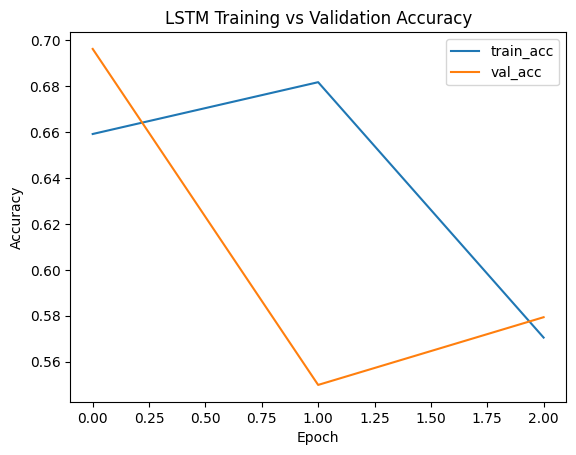

In [14]:
# Train LSTM model

from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)

history = lstm_model.fit(
    X_train_pad,
    y_train,
    epochs=5,
    batch_size=128,
    validation_split=0.1,
    callbacks=[early_stop],
    verbose=1
)


plt.figure()
plt.plot(history.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('LSTM Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


281/281 ━━━━━━━━━━━━━━━━━━━━ 13s 45ms/step
 LSTM 
Accuracy: 0.6907572383073497

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.48      0.62      4696
           1       0.62      0.92      0.74      4284

    accuracy                           0.69      8980
   macro avg       0.74      0.70      0.68      8980
weighted avg       0.75      0.69      0.68      8980



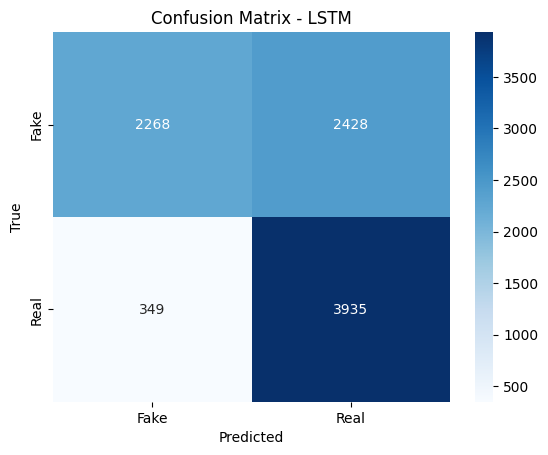


Updated model comparison:
                 Model  Accuracy
1        Random Forest  0.998218
2  Logistic Regression  0.988196
0          Naive Bayes  0.942762
3                 LSTM  0.690757


In [15]:
# Evaluate LSTM on test set

y_prob_lstm = lstm_model.predict(X_test_pad)

y_pred_lstm = (y_prob_lstm >= 0.5).astype(int).ravel()

evaluate_model("LSTM", y_test, y_pred_lstm, results)

results_df = pd.DataFrame(results).sort_values(by='Accuracy', ascending=False)
print("\nUpdated model comparison:")
print(results_df)


In [16]:
# Real-time prediction helper functions

def preprocess_single_text(text):
    """Apply the same cleaning as training pipeline."""
    return clean_text(text)

def predict_news_ml(text):
    """Predict using TF-IDF + Logistic Regression (fast, real-time)."""
    cleaned = preprocess_single_text(text)
    vec = tfidf.transform([cleaned])
    pred = log_reg_model.predict(vec)[0]
    label = "Real" if pred == 1 else "Fake"
    return label

def predict_news_lstm(text):
    """Predict using LSTM model."""
    cleaned = preprocess_single_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    pad = pad_sequences(seq, maxlen=MAX_LEN, padding='post', truncating='post')
    prob = lstm_model.predict(pad)[0][0]
    pred = 1 if prob >= 0.5 else 0
    label = "Real" if pred == 1 else "Fake"
    return label, float(prob)

sample_text = "Government announces new healthcare policy to benefit citizens."
print("ML prediction:", predict_news_ml(sample_text))
print("LSTM prediction:", predict_news_lstm(sample_text))


ML prediction: Fake
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
LSTM prediction: ('Real', 0.6081742644309998)
